# Background

# Setup

In [1]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 972.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 38.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 34.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully 

In [2]:
# set random seed to minimize randomness
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.utils import image_dataset_from_directory   # load as tf.data.Dataset
from tensorflow.data.experimental import cardinality              # get total num of batches -> split val&test
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # data augmentation
from tensorflow.keras.applications.resnet50 import ResNet50       # ResNet50 base model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import cv2

2.9.1


In [4]:
# SET CONSTANTS
IMG_DIR = '/kaggle/input/leukemia/Original'

IMG_SIZE = 224
NUM_CHANNELS = 3
NUM_CLASSES = 4
CLASS_NAMES = ['Benign', 'Early', 'Pre', 'Pro']

SHUFFLE_VALUE = True          # Shuffle images order
BATCH_SIZE = 8

VALIDATION_SPLIT = 0.3        # 70-30 train-val split
SEED_TRAIN_VAL = 420          # Must be same for train_ds and val_ds; reproducibility

# Load Dataset

In [5]:
# get train images
raw_train_ds = image_dataset_from_directory(
  directory = IMG_DIR,
  image_size = (IMG_SIZE,IMG_SIZE),
  validation_split = VALIDATION_SPLIT,
  batch_size = BATCH_SIZE,
  subset = "training",        # specify training subset
  seed = SEED_TRAIN_VAL,
  color_mode = 'rgb',
  shuffle = SHUFFLE_VALUE,
  label_mode = 'categorical'
)

raw_val_ds = image_dataset_from_directory(
  directory = IMG_DIR,
  image_size = (IMG_SIZE,IMG_SIZE),
  validation_split = VALIDATION_SPLIT,
  batch_size = BATCH_SIZE,
  subset = "validation",      # specify validation subset
  seed = SEED_TRAIN_VAL,
  color_mode = 'rgb',
  shuffle = SHUFFLE_VALUE,
  label_mode = 'categorical'
)

# split validation subset into 2: val & test
val_batches = cardinality(raw_val_ds)
raw_test_ds = raw_val_ds.take((2*val_batches) // 3)
raw_val_ds = raw_val_ds.skip((2*val_batches) // 3)

Found 3256 files belonging to 4 classes.
Using 2280 files for training.
Found 3256 files belonging to 4 classes.
Using 976 files for validation.


In [6]:
class preprocess:
  # data augmentation -> random transformation of train ds to avoid overfitting
  def aug_train_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_train_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_train_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  # data augmentation for val-test ds -> rescale pixel
  def aug_val_test_cv(self,img,lbl):
    datagen = ImageDataGenerator(
        rescale = 1./255
    )
    img = img.numpy().astype('uint8')
    img = datagen.random_transform(img)
    return img,lbl

  def aug_val_test_pyfunction(self,img,lbl):
    [img,lbl] = tf.py_function(self.aug_val_test_cv,[img,lbl],[tf.uint8,tf.float32])
    img = tf.cast(img,dtype=tf.float32)
    return img,lbl

  def _fixup_shape(self, img, lbl):
    img.set_shape([None, None, None, NUM_CHANNELS])
    lbl.set_shape([None, NUM_CLASSES])
    return img, lbl
  
  # do prep+aug
  def train(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_train_pyfunction).batch(batch_size)
    fin_ds = aug_ds.map(self._fixup_shape)
    return fin_ds
  
  def val_test(self,ds,batch_size=1):
    aug_ds = ds.unbatch().map(self.aug_val_test_pyfunction).batch(batch_size)
    fin_ds = aug_ds.map(self._fixup_shape)
    return fin_ds

In [7]:
train_fin_ds = preprocess().train(raw_train_ds,BATCH_SIZE)
val_fin_ds = preprocess().val_test(raw_val_ds,BATCH_SIZE)
test_fin_ds = preprocess().val_test(raw_test_ds,BATCH_SIZE)

In [8]:
def plot_batch(ds,title=''):
  plt.figure(figsize=(BATCH_SIZE*3, 9))
  plt.suptitle(title,fontweight='bold',fontsize=20)
  for images, labels in ds.take(1):
      for i in range(BATCH_SIZE):
          ax = plt.subplot(3, BATCH_SIZE, i + 1)
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.title(CLASS_NAMES[np.argmax(labels[i].numpy(), axis=-1)])
          plt.axis("off")

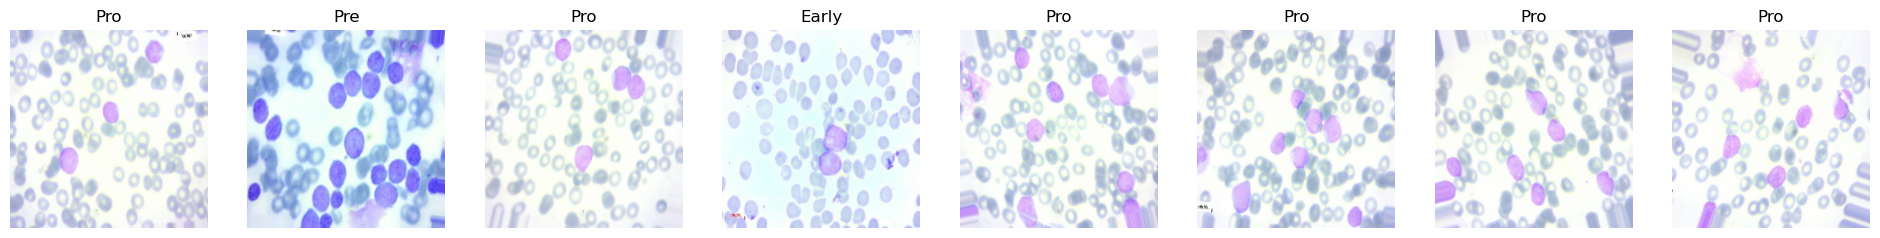

In [9]:
plot_batch(train_fin_ds)

# Comparison

In [10]:
#Create metrics. Code from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
def pre_vgg19(img,lbl):
  return tf.keras.applications.vgg19.preprocess_input(img),lbl

def pre_efficientnetb0(img,lbl):
  return tf.keras.applications.efficientnet.preprocess_input(img),lbl

def pre_resnet50(img,lbl):
  return tf.keras.applications.resnet50.preprocess_input(img),lbl

In [12]:
def get_model_hist_rep(train_ds,val_ds,test_ds,base_type='ResNet50',num_epoch1=3,num_epoch2=10,method=''):
  # Reference: https://www.kaggle.com/code/drscarlat/melanoma-resnet50-fine-tune/notebook
  # Convoluted Base MODEL
  if base_type=='VGG19':
    train_ds = train_ds.map(pre_vgg19)
    val_ds = val_ds.map(pre_vgg19)
    test_ds = test_ds.map(pre_vgg19)
    NUM_LAST_BLOCK = 17
    conv_base = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))
    
  elif base_type=='EfficientNetB0':
    train_ds = train_ds.map(pre_efficientnetb0)
    val_ds = val_ds.map(pre_efficientnetb0)
    test_ds = test_ds.map(pre_efficientnetb0)
    NUM_LAST_BLOCK = 222
    conv_base = EfficientNetB0(weights='imagenet',
                               include_top=False,
                               input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))
  else:
    train_ds = train_ds.map(pre_resnet50)
    val_ds = val_ds.map(pre_resnet50)
    test_ds = test_ds.map(pre_resnet50)
    NUM_LAST_BLOCK = 165
    conv_base = ResNet50(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))
    
  # MODEL
  model = Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

  # Make the conv_base NOT trainable:
  for layer in conv_base.layers[:]:
    layer.trainable = False

  # Compile frozen conv_base + my top layer
  model.compile(optimizer=optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy',f1_m])

  # Short training ONLY my top layers 
  #... so the conv_base weights will not be destroyed by the random intialization of the new weights
  history = model.fit(train_ds,
                      epochs=num_epoch1,
                      validation_data = val_ds,
                      batch_size=BATCH_SIZE,
                      shuffle=False)

  # Make last block of the conv_base trainable:
  for layer in conv_base.layers[:NUM_LAST_BLOCK]:
    layer.trainable = False
  for layer in conv_base.layers[NUM_LAST_BLOCK:]:
    layer.trainable = True

  model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy',f1_m])
  
  # set callbacks
  model_filename = f'/kaggle/working/models/all_{method}.h5'
  save_best_model = ModelCheckpoint(filepath = model_filename,
                                   monitor = 'val_f1_m',
                                   mode = 'max',
                                   verbose = 1,
                                   save_best_only = True)
  early_stopping = EarlyStopping(monitor='val_f1_m',patience=5,mode='max')

  history = model.fit(train_ds,
                      epochs=num_epoch2,
                      validation_data = val_ds,
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      callbacks=[save_best_model,early_stopping])
  
  y_pred = []  # store predicted labels
  y_true = []  # store true labels
  # iterate over the dataset
  for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
    # append true labels
    truth = np.argmax(label_batch, axis=1)
    y_true.append(truth)
    # compute predictions
    preds = model.predict(image_batch,verbose=0)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))
  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)
  # classification report
  report = classification_report(correct_labels, predicted_labels, digits= 4, output_dict=True,)
  report_df = pd.DataFrame(report).transpose()
  # confusion mtx
  conf_mtx = confusion_matrix(correct_labels, predicted_labels)

  return history, report_df, conf_mtx

In [13]:
def get_model_all(train_ds,val_ds,test_ds,models=[],num_epoch1=3,num_epoch2=10):
  histories = []
  reports = []
  conf_mtxs = []
  acc_tests = []
  f1_tests = []
  for model in models:
    print(f'STARTING TRAINING FOR {model} MODEL')
    hist, rep, conf = get_model_hist_rep(train_ds,val_ds,test_ds,base_type=model,num_epoch1=num_epoch1,num_epoch2=num_epoch2,method=f'{model}')
    histories.append(hist)
    reports.append(rep)
    conf_mtxs.append(conf)
    # Accuracy for the test dataset
    acc = {}
    acc['model'] = f'Model {model}'
    acc['accuracy'] = rep['f1-score']['accuracy']
    acc_tests.append(acc)
    # F1 for the test dataset
    for i in range(NUM_CLASSES):
      f1 = {}
      f1['model'] = f'Model {model}'
      f1['label'] = i
      f1['f1-score'] = rep['f1-score'][i]
      f1_tests.append(f1)

  # SIDE BY SIDE
  # plot training acc
  fig1, axes1 = plt.subplots(ncols=2,nrows=1,figsize=(40,10))
  fig1.subplots_adjust(top=0.8)
  col = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
  for i in range(len(histories)):
    acc = histories[i].history['accuracy']
    epochs = range(1, len(acc) + 1)
    axes1[0].plot(epochs, acc, 'r', label=f'Model {models[i]} acc', color=col[i])
  axes1[0].set_title('Training Accuracies of Each Model',fontweight='bold',fontsize=20)
  axes1[0].legend()
  # plot validation acc
  for i in range(len(histories)):
    val_acc = histories[i].history['val_accuracy']
    epochs = range(1, len(val_acc) + 1)
    axes1[1].plot(epochs, val_acc, 'r', label=f'Model {models[i]} val acc', color=col[i])
  axes1[1].set_title('Validation Accuracies of Each Model',fontweight='bold',fontsize=20)
  axes1[1].legend()
  plt.show()

  # SIDE BY SIDE
  # plot training f1_m
  fig2, axes2 = plt.subplots(ncols=2,nrows=1,figsize=(40,10))
  fig2.subplots_adjust(top=0.8)
  col = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
  for i in range(len(histories)):
    f1_m = histories[i].history['f1_m']
    epochs = range(1, len(f1_m) + 1)
    axes2[0].plot(epochs, f1_m, 'r', label=f'Model {models[i]} f1_m', color=col[i])
  axes2[0].set_title('Training F1-Scores of Each Model',fontweight='bold',fontsize=20)
  axes2[0].legend()
  # plot validation acc
  for i in range(len(histories)):
    val_f1_m = histories[i].history['val_f1_m']
    epochs = range(1, len(val_f1_m) + 1)
    axes2[1].plot(epochs, val_f1_m, 'r', label=f'Model {models[i]} val f1_m', color=col[i])
  axes2[1].set_title('Validation F1-Scores of Each Model',fontweight='bold',fontsize=20)
  axes2[1].legend()
  plt.show()

  # BAR PLOT
  # accuracy
  acc_tests = pd.DataFrame(acc_tests)
  fig_acc_test = plt.figure(figsize=(20,10))
  ax1 = sns.barplot(data=acc_tests,x='model',y='accuracy')
  for patch in ax1.patches:
      x0, y0 = patch.get_xy()   # Bottom-left corner. 
      x0 += patch.get_width()/2 # Middle of the width.
      y0 += patch.get_height()  # Top of the bar
      ax1.text(x0, y0, str("{:.2f}".format(y0)), ha="center", va="bottom",color='black', clip_on=True)
  plt.title('Test Accuracy Comparison\nFor Each Model',fontweight='bold',fontsize=20)
  plt.show()
  # f1
  f1_tests = pd.DataFrame(f1_tests)
  fig_f1_test = plt.figure(figsize=(20,10))
  ax2 = sns.barplot(data=f1_tests,x='label',y='f1-score',hue='model')
  for patch in ax2.patches:
      x0, y0 = patch.get_xy()   # Bottom-left corner. 
      x0 += patch.get_width()/2 # Middle of the width.
      y0 += patch.get_height()  # Top of the bar
      ax2.text(x0, y0, str("{:.2f}".format(y0)), ha="center", va="bottom",color='black', clip_on=True)
  plt.title('Categorical F1-Score Comparison\nFor Each Model',fontweight='bold',fontsize=20)
  plt.show()

  return histories, reports, conf_mtxs

STARTING TRAINING FOR VGG19 MODEL
80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/3
285/285 [==============================] - 48s 150ms/step - loss: 1.9197 - accuracy: 0.4531 - f1_m: 0.3017 - val_loss: 0.8727 - val_accuracy: 0.7439 - val_f1_m: 0.5875
Epoch 2/3
285/285 [==============================] - 39s 138ms/step - loss: 1.1734 - accuracy: 0.5259 - f1_m: 0.3672 - val_loss: 0.7212 - val_accuracy: 0.7683 - val_f1_m: 0.7268
Epoch 3/3
285/285 [==============================] - 41s 145ms/step - loss: 1.0537 - accuracy: 0.5868 - f1_m: 0.4688 - val_loss: 0.7154 - val_accuracy: 0.7591 - val_f1_m: 0.7412
Epoch 1/100
    285/Unknown - 40s 134ms/step - loss: 0.8776 - accuracy: 0.6877 - f1_m: 0.6043
Epoch 1: val_f1_m improved from -inf to 0.83814, saving model to /kaggle/working/models/all_VGG19.h5
285/285 [==============================] - 43s 146ms/step - loss: 0.8776 - accuracy: 0.6877 - f1_m: 0.6043 - val_loss: 0.6460 - val_accuracy: 0.8659 - val_f1_m: 0.8381
Epoc

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


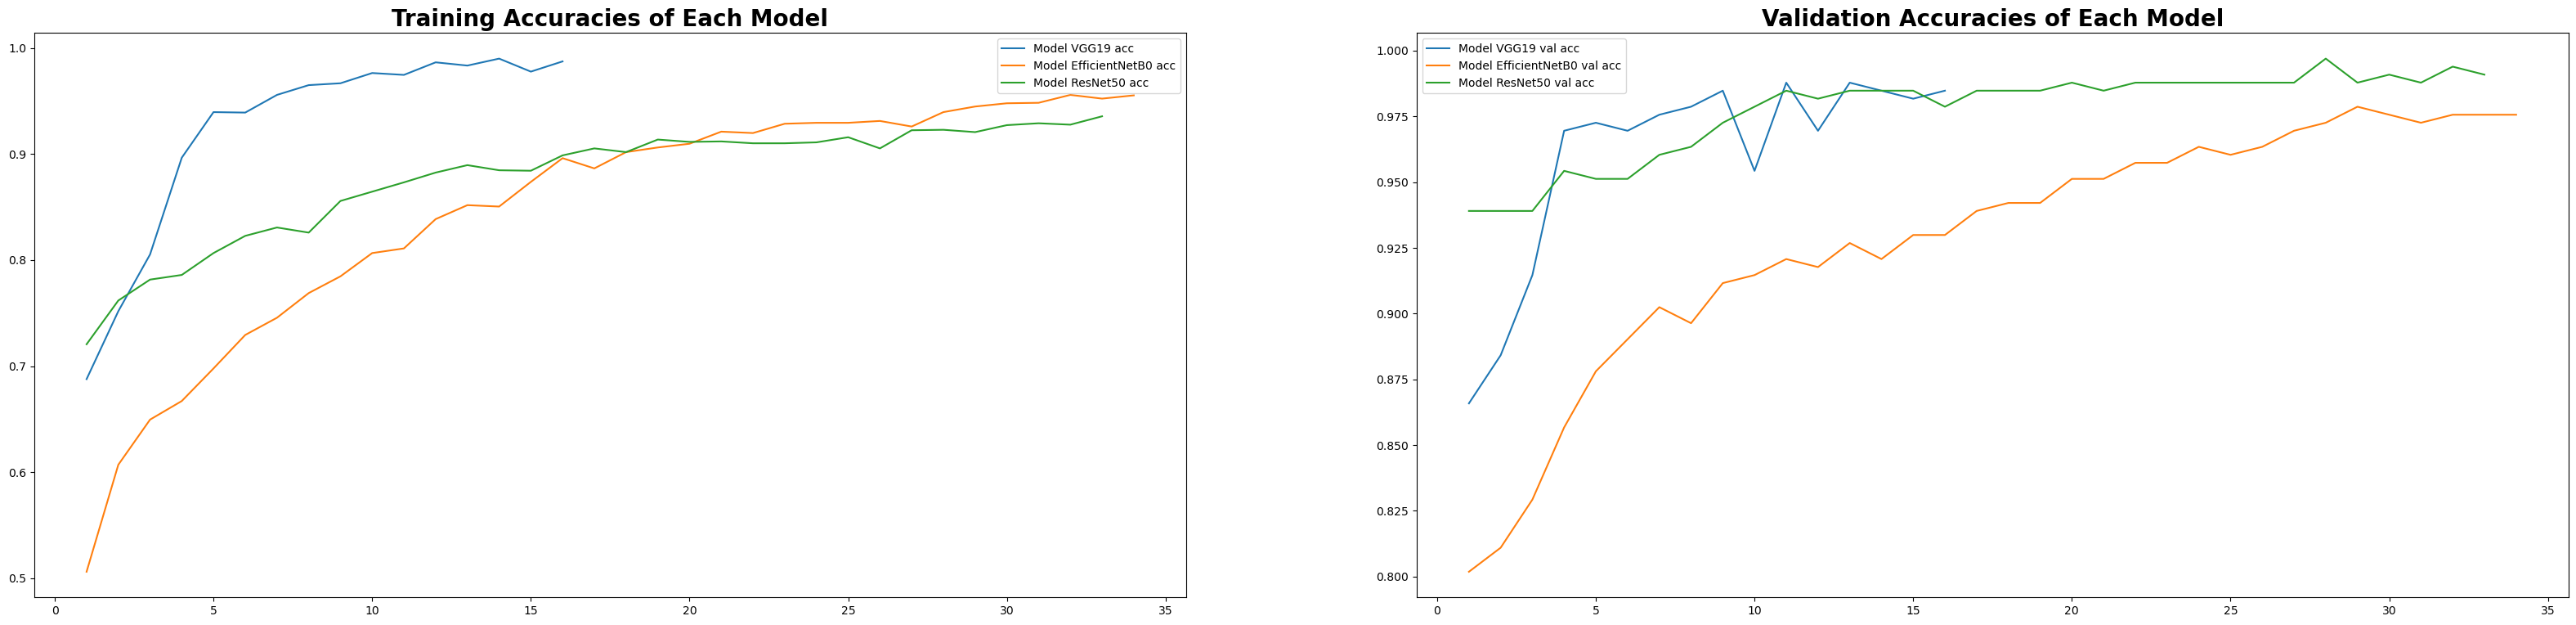

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


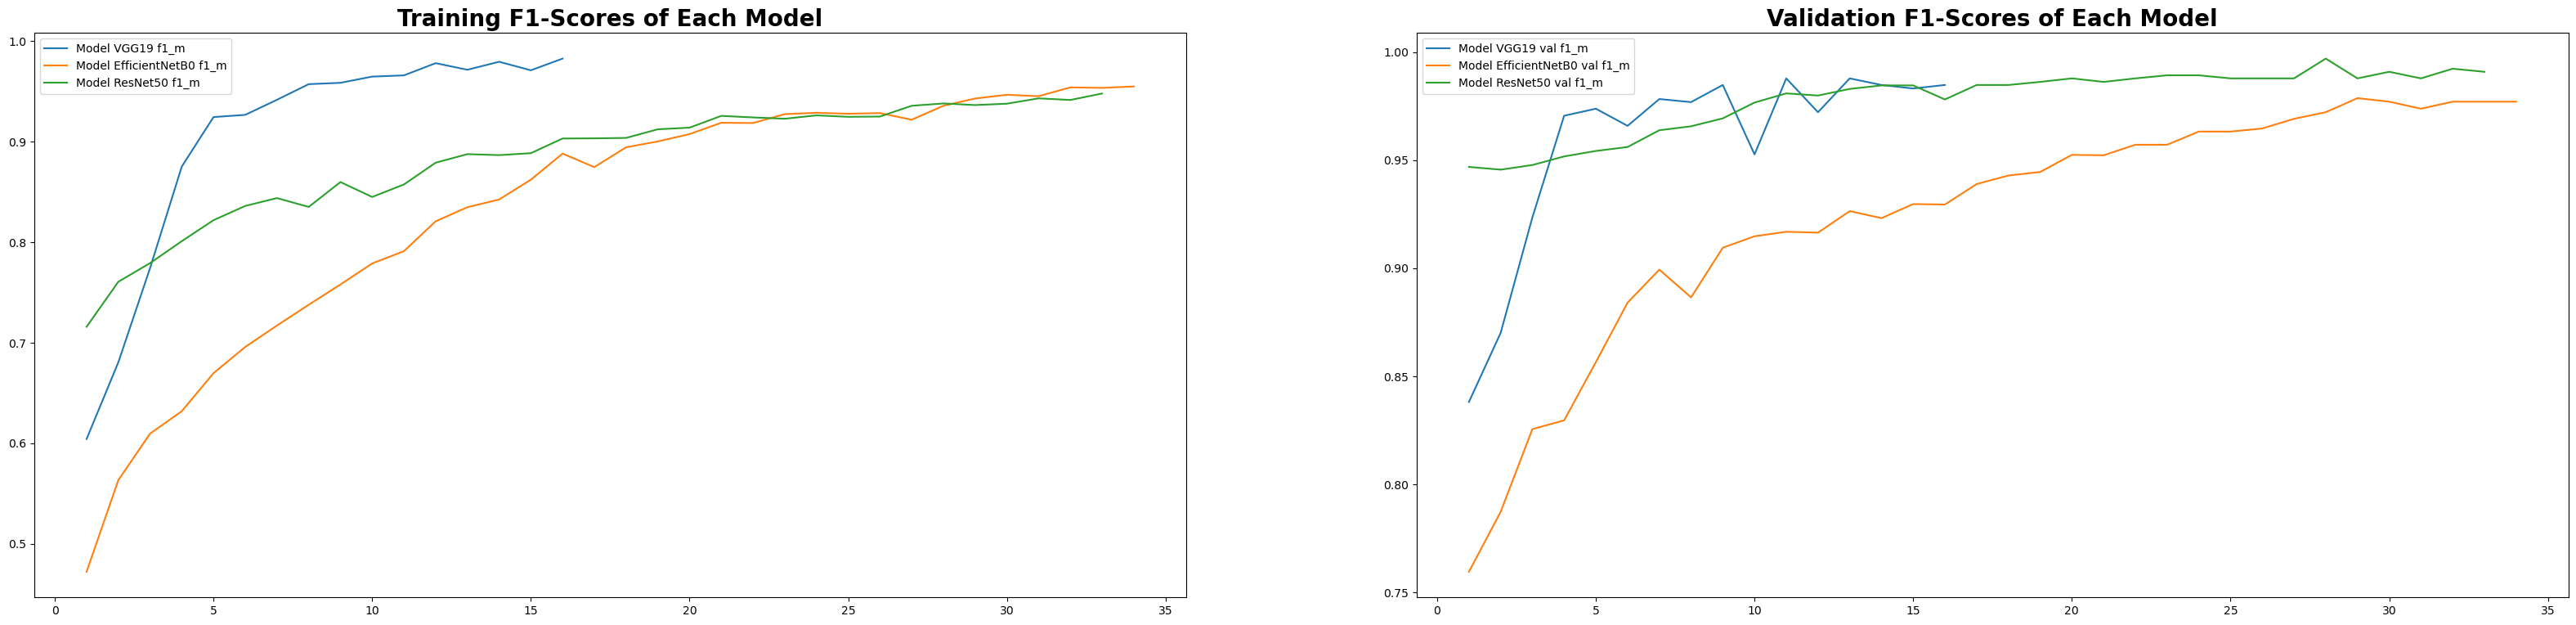

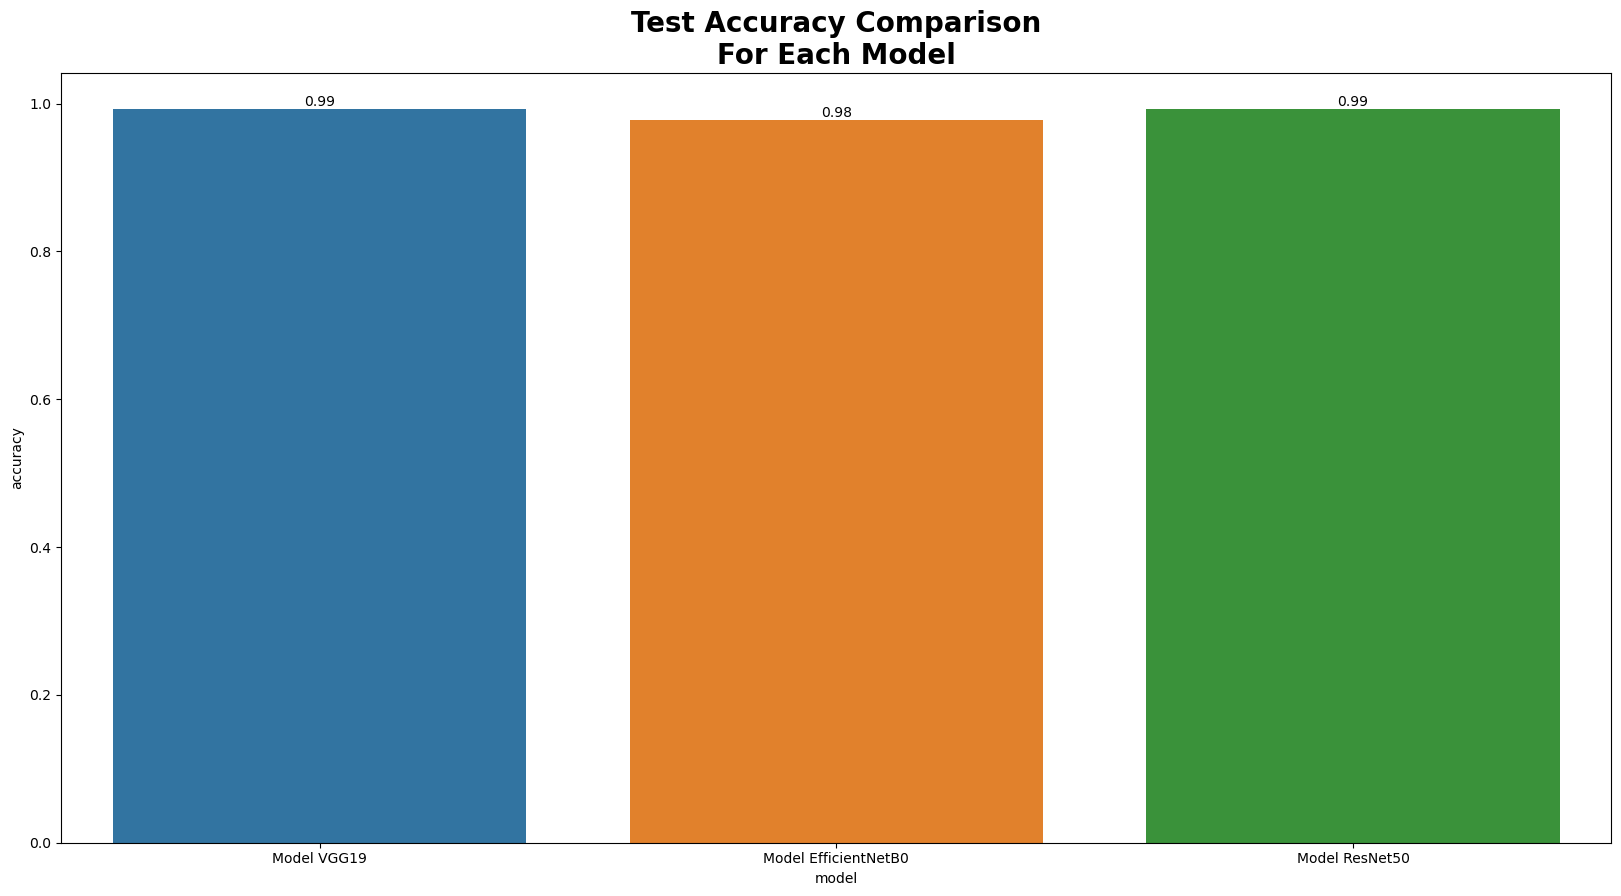

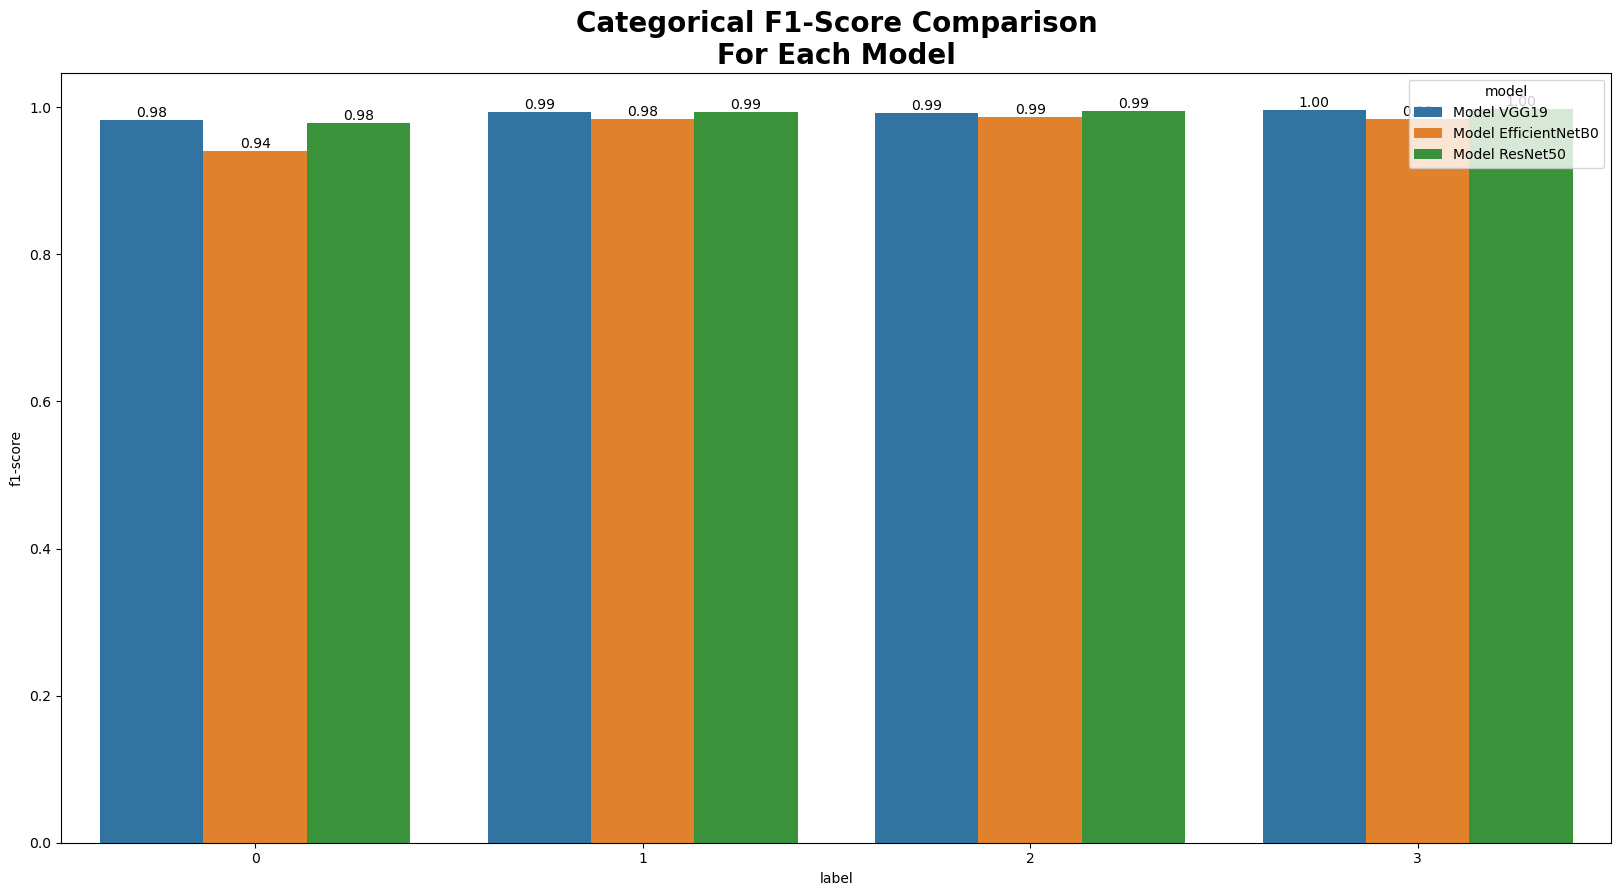

In [14]:
models = ['VGG19','EfficientNetB0','ResNet50']
histories, reports, conf_mtxs = get_model_all(train_fin_ds,val_fin_ds,test_fin_ds,models=models,num_epoch1=3,num_epoch2=100)

## Reports

In [15]:
reports[0] # VGG19

,precision,recall,f1-score,support
0,0.988636,0.977528,0.983051,89.000000
1,0.986486,1.000000,0.993197,219.000000
2,1.000000,0.983696,0.991781,184.000000
3,0.993631,1.000000,0.996805,156.000000
accuracy,0.992284,0.992284,0.992284,0.992284
macro avg,0.992188,0.990306,0.991209,648.000000
weighted avg,0.992339,0.992284,0.992270,648.000000


In [16]:
reports[1]  # EfficientNet

,precision,recall,f1-score,support
0,0.945652,0.935484,0.940541,93.000000
1,0.981395,0.985981,0.983683,214.000000
2,0.983696,0.989071,0.986376,183.000000
3,0.987261,0.981013,0.984127,158.000000
accuracy,0.978395,0.978395,0.978395,0.978395
macro avg,0.974501,0.972887,0.973682,648.000000
weighted avg,0.978345,0.978395,0.978360,648.000000


In [17]:
reports[2]  # ResNet50

,precision,recall,f1-score,support
0,0.967391,0.988889,0.978022,90.000000
1,0.995349,0.990741,0.993039,216.000000
2,1.000000,0.988701,0.994318,177.000000
3,0.993976,1.000000,0.996979,165.000000
accuracy,0.992284,0.992284,0.992284,0.992284
macro avg,0.989179,0.992083,0.990590,648.000000
weighted avg,0.992387,0.992284,0.992306,648.000000


## Confusion Matrices

In [18]:
conf_mtxs[0]  # VGG19

array([[ 87,   2,   0,   0],
       [  0, 219,   0,   0],
       [  1,   1, 181,   1],
       [  0,   0,   0, 156]])

In [19]:
conf_mtxs[1] # EfficientNetB0

array([[ 87,   4,   1,   1],
       [  3, 211,   0,   0],
       [  1,   0, 181,   1],
       [  1,   0,   2, 155]])

In [20]:
conf_mtxs[2]  # ResNet50

array([[ 89,   1,   0,   0],
       [  2, 214,   0,   0],
       [  1,   0, 175,   1],
       [  0,   0,   0, 165]])

# Conclusion
This shows that VGG19 and ResNet50 perform equally well when the trainings have stabilized, but VGG19 is a lighter model with less layers than ResNet50 which should be taken into account when trying to deploy an ALL detection model.